In [ ]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#View the content of Google Drive
!ls /content/gdrive/My\ Drive/TA/1082

In [3]:
#Import package
%tensorflow_version 1.x
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.applications.vgg16 import VGG16
from keras import layers
from keras import models
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

TensorFlow 1.x selected.


Using TensorFlow backend.


# **VGG16 model**

In [4]:
model = models.Sequential()

In [5]:
conv_base = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))




58892288/58889256 [==============================] - 6s 0us/step








In [7]:
#Freeze all layers
for layer in conv_base.layers:
    layer.trainable = False

#Make some layer be trainable
conv_base.get_layer('block5_conv1').trainable = True
conv_base.get_layer('block5_conv2').trainable = True
conv_base.get_layer('block5_conv3').trainable = True
conv_base.get_layer('block5_pool').trainable = True

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dense(3, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 17,926,467
Trainable params: 10,291,203
Non-trainable params: 7,635,264
_________________________________________________________________


In [8]:
opt = optimizers.SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# **Prepare dataset**

In [9]:
data = np.load('/content/gdrive/My Drive/TA/1082/mango_train_planet_data.npz')
X, Y = data['arr_0'], data['arr_1']
print('Loaded shape: ', X.shape, Y.shape)

Loaded shape:  (5600, 224, 224, 3) (5600, 3)


In [10]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=1)
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(4480, 224, 224, 3) (4480, 3) (1120, 224, 224, 3) (1120, 3)


In [0]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0, rotation_range=15, featurewise_center=True, horizontal_flip=True)
train_datagen.mean = [0.485, 0.456, 0.406]

test_datagen = ImageDataGenerator(rescale=1.0/255.0, featurewise_center=True)
test_datagen.mean = [0.485, 0.456, 0.406]

train_it = train_datagen.flow(trainX, trainY, batch_size=128)
test_it = test_datagen.flow(testX, testY, batch_size=128)

# **Train model**

In [0]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpoint = ModelCheckpoint('/content/gdrive/My Drive/TA/1082/TestCNN2_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, period=1)

In [13]:
history = model.fit_generator(train_it, steps_per_epoch=len(train_it), epochs=100, validation_data=test_it, validation_steps=len(test_it), callbacks=[checkpoint, early_stopping])



Epoch 1/100
35/35 [==============================] - 70s 2s/step - loss: 0.5606 - acc: 0.6997 - val_loss: 0.4515 - val_acc: 0.7473

Epoch 00001: val_loss improved from inf to 0.45146, saving model to /content/gdrive/My Drive/TA/1082/TestCNN2_weights.h5
Epoch 2/100
35/35 [==============================] - 49s 1s/step - loss: 0.4578 - acc: 0.7661 - val_loss: 0.4427 - val_acc: 0.7661

Epoch 00002: val_loss improved from 0.45146 to 0.44268, saving model to /content/gdrive/My Drive/TA/1082/TestCNN2_weights.h5
Epoch 3/100
35/35 [==============================] - 52s 1s/step - loss: 0.4345 - acc: 0.7844 - val_loss: 0.3923 - val_acc: 0.8128

Epoch 00003: val_loss improved from 0.44268 to 0.39234, saving model to /content/gdrive/My Drive/TA/1082/TestCNN2_weights.h5
Epoch 4/100
35/35 [==============================] - 53s 2s/step - loss: 0.3873 - acc: 0.8147 - val_loss: 0.4927 - val_acc: 0.7551

Epoch 00004: val_loss did not improve from 0.39234
Epoch 5/100
35/35 [=============================

# **Save and draw**

In [0]:
model.save('/content/gdrive/My Drive/TA/1082/TestCNN2.h5')

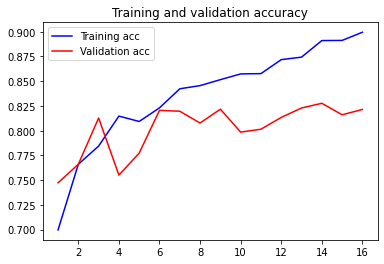

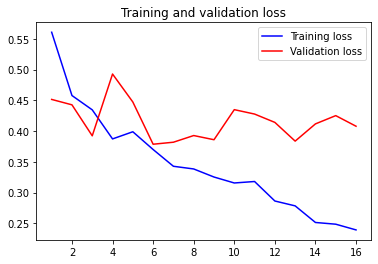

In [15]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('/content/gdrive/My Drive/TA/1082/VGG16-accuracy.png')

plt.figure()

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('/content/gdrive/My Drive/TA/1082/VGG16-loss.png')

plt.show()

# **Evaluate and predict**

In [16]:
#Load dev dataset
data = np.load('/content/gdrive/My Drive/TA/1082/mango_dev_planet_data.npz')
X, Y = data['arr_0'], data['arr_1']
print('Loaded shape: ', X.shape, Y.shape)

Loaded shape:  (800, 224, 224, 3) (800, 3)


In [0]:
#Load model
model = models.load_model('/content/gdrive/My Drive/TA/1082/TestCNN2.h5')

In [0]:
#Load model weights
model.load_weights('/content/gdrive/My Drive/TA/1082/TestCNN2_weights.h5')

In [19]:
#Rescale dev dataset
X/=255.0
print(X)

[[[[0.34509805 0.3647059  0.3764706 ]
   [0.3254902  0.34509805 0.35686275]
   [0.32941177 0.34901962 0.36078432]
   ...
   [0.38039216 0.3137255  0.09411765]
   [0.3882353  0.32156864 0.10196079]
   [0.38431373 0.31764707 0.09803922]]

  [[0.34117648 0.36078432 0.37254903]
   [0.3254902  0.34509805 0.35686275]
   [0.33333334 0.3529412  0.3647059 ]
   ...
   [0.4        0.30980393 0.09803922]
   [0.40784314 0.31764707 0.10588235]
   [0.39607844 0.30588236 0.09411765]]

  [[0.32156864 0.3529412  0.36078432]
   [0.31764707 0.34901962 0.35686275]
   [0.29411766 0.3254902  0.33333334]
   ...
   [0.44705883 0.36078432 0.13333334]
   [0.43529412 0.34901962 0.12156863]
   [0.4117647  0.3254902  0.09803922]]

  ...

  [[0.56078434 0.5411765  0.5294118 ]
   [0.5686275  0.54901963 0.5372549 ]
   [0.5764706  0.5568628  0.54509807]
   ...
   [0.5529412  0.654902   0.65882355]
   [0.5294118  0.6313726  0.63529414]
   [0.50980395 0.6117647  0.6156863 ]]

  [[0.57254905 0.5372549  0.5176471 ]
   [0.5

In [20]:
#Evaluate
loss, acc = model.evaluate(X, Y)
print('Loss = %.5f, Acc = %.5f' % (loss, acc))

800/800 [==============================] - 7s 9ms/step
Loss = 0.41068, Acc = 0.80750


In [0]:
#Predict result
y_predict = model.predict_classes(X)
print(len(y_predict))
print(y_predict)

800
[1 0 1 1 2 1 2 0 0 0 0 1 2 1 1 1 1 0 0 1 1 0 2 0 1 0 2 2 0 1 0 0 1 2 0 0 0
 0 0 0 0 1 0 1 2 2 1 0 2 0 1 1 1 1 1 0 1 1 2 0 0 0 2 0 0 2 1 0 2 1 2 1 1 2
 2 1 0 1 2 0 0 2 1 1 2 2 2 1 1 1 1 1 0 2 1 2 1 0 2 1 1 1 1 2 1 1 0 0 1 2 2
 0 1 0 0 2 2 1 0 0 1 0 2 1 2 1 0 1 2 1 0 0 2 1 0 2 1 1 0 2 1 0 2 0 1 0 1 1
 1 1 1 0 1 1 1 0 1 0 2 1 2 1 1 1 2 2 0 2 0 2 1 1 2 2 2 2 0 1 0 1 2 1 0 2 1
 2 0 1 2 1 2 2 1 1 1 0 0 2 2 0 2 0 1 0 1 0 0 0 2 2 2 1 0 2 1 2 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 0 2 0 2 0 1 1 2 0 1 0 0 2 2 1 1 0 2 2 2 1 1 1 2
 2 2 1 1 0 2 1 1 0 1 1 2 1 1 0 0 2 2 1 1 0 1 0 1 2 1 0 1 2 1 2 2 0 2 1 1 1
 1 1 1 2 2 0 2 0 2 2 1 2 1 2 2 0 2 1 0 2 1 1 1 0 0 1 1 1 2 1 1 1 1 2 1 0 2
 1 1 1 1 2 0 1 1 2 0 1 0 0 0 0 0 1 2 1 1 0 1 0 0 2 1 0 0 1 1 0 2 1 0 1 1 0
 2 0 1 1 0 1 1 2 0 2 0 1 0 1 1 2 1 2 0 2 2 2 0 2 1 0 1 2 0 0 0 1 2 1 0 1 0
 0 2 1 0 1 1 0 1 2 1 2 2 1 0 0 0 2 0 2 1 1 1 1 1 0 0 0 1 2 1 1 0 0 1 0 1 0
 0 1 0 1 1 1 2 2 1 2 0 1 0 1 0 1 2 0 2 1 0 1 1 0 1 0 1 2 2 2 0 1 2 1 0 1 0
 0 0 0 1 1 0 1 2 2 1 

In [0]:
#dev dataset label
Y_cat = Y.argmax(axis=-1)
print(Y_cat)

[1 0 1 1 2 1 2 0 1 0 0 1 2 1 2 1 1 0 0 1 0 0 2 0 1 0 2 2 1 1 1 0 2 2 0 0 0
 0 0 0 1 2 0 2 2 2 1 0 2 0 1 1 1 2 2 0 1 0 2 0 1 1 2 0 1 2 2 0 2 1 2 1 1 2
 2 2 1 0 2 0 0 2 1 1 2 2 2 2 0 1 2 2 1 2 2 2 1 0 2 2 2 1 1 2 1 1 1 1 1 2 2
 0 1 0 0 2 2 0 2 0 1 0 2 1 2 1 0 1 2 1 0 0 0 1 0 2 1 1 0 2 0 1 2 0 0 0 2 1
 1 1 1 1 1 1 1 1 1 0 2 1 2 1 0 1 2 2 1 2 0 2 1 2 2 2 2 1 0 0 0 1 2 2 0 2 1
 2 0 0 2 1 2 2 1 1 2 1 0 2 1 0 2 2 1 0 1 2 0 1 2 2 2 1 1 2 0 2 1 2 1 1 0 1
 1 1 1 1 0 0 1 1 0 2 1 1 0 1 2 0 2 0 1 2 2 0 1 0 2 2 2 1 0 1 2 2 2 1 1 1 2
 2 2 1 1 0 2 1 2 0 1 2 2 1 1 1 1 2 2 0 2 0 1 0 0 1 1 1 1 2 1 2 2 0 2 2 1 1
 0 1 1 2 2 0 2 0 2 2 1 2 1 2 2 0 2 1 0 2 0 1 1 0 0 1 1 2 2 1 1 1 0 2 1 1 2
 0 2 1 1 2 1 1 1 2 0 2 0 0 0 0 0 1 2 1 2 0 1 0 1 2 1 0 0 1 0 0 2 1 1 1 1 1
 2 2 1 2 0 2 1 2 0 2 0 1 0 1 1 2 1 1 0 2 2 2 1 2 1 0 1 1 1 1 0 0 2 1 0 2 1
 1 2 0 0 2 1 0 1 1 1 2 2 1 1 0 0 2 0 2 1 1 1 2 2 0 2 0 1 2 2 1 1 0 1 0 1 0
 0 1 0 1 1 1 2 2 2 2 0 0 0 1 0 2 2 1 2 2 0 1 1 0 1 0 1 2 2 1 0 1 2 1 1 1 0
 0 0 0 1 2 1 1 2 2 1 2 1 

# **Confusion Matrix**

In [0]:
#Confusion matrix by pandas
pd.crosstab(Y_cat, y_predict, rownames=['labels'], colnames=['prediction'])

prediction,0,1,2
labels,,,
0,181,58,4
1,56,220,17
2,10,65,189


In [0]:
#Confusion matrix by sklearn
c = confusion_matrix(Y_cat, y_predict)
print(c)

[[181  58   4]
 [ 56 220  17]
 [ 10  65 189]]


In [0]:
#Precison, recall and f1-score
print(classification_report(Y_cat, y_predict, target_names=['A', 'B', 'C']))

              precision    recall  f1-score   support

           A       0.73      0.74      0.74       243
           B       0.64      0.75      0.69       293
           C       0.90      0.72      0.80       264

    accuracy                           0.74       800
   macro avg       0.76      0.74      0.74       800
weighted avg       0.75      0.74      0.74       800

